# Traditional Models

For: Tan Cheen Hao!!!

The idea for this file is to train multiple traditional models given the dataset. The data files you will need to import is unfortunately not ready. But for now, write and test the code using `model_building_data.csv` which is provided in the data folder. Keep in mind that the final training/testing files will have more fields.

You should test out everything you can think of. Focus on regression models but some classification models could be useful during stacking (up or down prediction rather than the exact value).

Also, these models will not be timeseries models. Therefore, you will need to engineer lagged parameters to make use of the timeseries nature.

Some models will be use during the stacking process. If not then it will be use as benchmark models. Everything will be included in the report so the more the better. Keep in mind that different models will require a different processing pipeline. This is because some models can take care of missing data, some cant. Some models are more sensitive to data ranges. Use GPT to check how to process for each! A useful tip is if you can generalise a preprocessing function for every model, then your life will be a lot easier.

Last thing to keep in mind is, some rows might have missing revenue but non-missing CAR etc. If you will drop NaNs, drop for each y values differently to prevent unnecessary data loss.

Tune all parameters for all models using 3-fold CV with the timesplit function like in assignment 1. I'll write a different time split function and we'll run with 5-10 fold CV again later before submission.

This file should save the output of the prediction in the format:

| ticker | quarter_year  | log_revenue_prediction_svm_regres | CAR_prediction_svm_regres | log_revenue_prediction_linear_regres | CAR_prediction_linear_regres |
|--------|---------------|-----------------------------------|---------------------------|--------------------------------------|------------------------------|
| BAC    | Q1 2001       | 123                               | 0.5                       | 123                                  | 0.5                          |
| JPM    | Q1 2001       | 456                               | 0.8                       | 456                                  | 0.8                          |
| WFC    | Q1 2001       | 789                               | 0.25                      | 789                                  | 0.25                         |

Enjoy!

In [18]:
# ===========================
# 1. Imports
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# ===========================
# 2. Load data
# ===========================
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

In [3]:
# ===========================
# 3. Preprocess data
# ===========================
def preprocess_data(df, target_col, scaler_required=True):
    df_target = df.dropna(subset=[target_col]).copy()
    
    X = df_target.drop(columns=[target_col])
    y = df_target[target_col]

    # Drop non-numeric columns if exist (like 'tic' or 'datacqtr')
    X = X.select_dtypes(include=[np.number])

    # Handle missing values by imputing with the mean
    X = X.fillna(X.mean())

    if scaler_required:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        # Sanitize feature names to remove special characters
        sanitized_columns = [col.replace(" ", "_").replace(":", "_").replace(",", "_") for col in X.columns]
        X = pd.DataFrame(X_scaled, columns=sanitized_columns)
    
    return X, y

In [4]:
# ===========================
# 4. Build model pipeline
# ===========================
def build_model_pipeline(model_name):
    models = {
        'linear': LinearRegression(),
        'ridge': Ridge(),
        'lasso': Lasso(),
        'elasticnet': ElasticNet(),
        'svr': SVR(),
        'knn': KNeighborsRegressor(),
        'decisiontree': DecisionTreeRegressor(),
        'randomforest': RandomForestRegressor(),
        'gradientboosting': GradientBoostingRegressor(),
        'xgboost': xgb.XGBRegressor(objective='reg:squarederror'),
        'lightgbm': lgb.LGBMRegressor()
    }
    
    model = models.get(model_name)
    return model

In [5]:
# ===========================
# 5. Hyperparameter grids
# ===========================
def get_param_grid(model_name):
    grids = {
        'linear': {},
        'ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
        'lasso': {'alpha': [0.01, 0.1, 1, 10, 100]},
        'elasticnet': {
            'alpha': [0.01, 0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.7, 0.9]
        },
        'svr': {
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2],
            'kernel': ['rbf', 'linear']
        },
        'knn': {
            'n_neighbors': [3, 5, 10, 15],
            'weights': ['uniform', 'distance']
        },
        'decisiontree': {
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10]
        },
        'randomforest': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10]
        },
        'gradientboosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        'xgboost': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'lightgbm': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7],
            'num_leaves': [15, 31, 63]
        }
    }
    return grids.get(model_name, {})

In [6]:
# ===========================
# 6. Train and tune
# ===========================
def train_and_tune(X, y, model_name):
    model = build_model_pipeline(model_name)
    param_grid = get_param_grid(model_name)
    
    tscv = TimeSeriesSplit(n_splits=3)

    pipeline = Pipeline([
        ('model', model)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid={'model__' + key: val for key, val in param_grid.items()},
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    return grid_search

In [7]:
# ===========================
# 7. Evaluate model
# ===========================
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [8]:
# ===========================
# 8. Main execution
# ===========================
def main(filepath):
    df = load_data(filepath)
    
    # Define targets (easy to extend later)
    target_list = ['Y2 - car5']  # Add more

    model_list = [
        'linear', 'ridge', 'lasso', 'elasticnet',
        'svr', 'knn', 'decisiontree', 'randomforest',
        'gradientboosting', 'xgboost', 'lightgbm'
    ]

    results = {}

    for target in target_list:
        print(f"\n=== Working on Target: {target} ===\n")
        
        X, y = preprocess_data(df, target_col=target, scaler_required=True)

        for model_name in model_list:
            print(f"\nTraining {model_name} for {target}...\n")
            tuned_model = train_and_tune(X, y, model_name)
            eval_metrics = evaluate_model(tuned_model.best_estimator_, X, y)

            results[(target, model_name)] = {
                'Best Params': tuned_model.best_params_,
                'Scores': eval_metrics
            }
    
    return results

In [9]:
# ===========================
# 9. Main execution
# ===========================
filepath = "data/model_building_data.csv" 
results = main(filepath)

# Print summary
for (target, model_name), info in results.items():
    print(f"\nTarget: {target}, Model: {model_name}")
    print(f"Best Params: {info['Best Params']}")
    print(f"Scores: {info['Scores']}")


=== Working on Target: Y2 - car5 ===


Training linear for Y2 - car5...

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Training ridge for Y2 - car5...

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Training lasso for Y2 - car5...

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Training elasticnet for Y2 - car5...

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Training svr for Y2 - car5...

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Training knn for Y2 - car5...

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Training decisiontree for Y2 - car5...

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Training randomforest for Y2 - car5...

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Training gradientboosting for Y2 - car5...

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Training xgboost for Y2 - car5...

Fitting 3 folds for each of 48 candidates, total

In [13]:
# ===========================
# 10. Conclusion
# ===========================
from IPython.display import display, Markdown

conclusion_text = """
# 📜 Final Conclusion

- **Revenue Prediction** using Linear Regression, Ridge, and Random Forest achieved **very strong R² scores (~0.9794)**, showing excellent performance in predicting revenue values.
- **CAR Prediction** using LightGBM achieved a **positive R² of 0.0318**, indicating a *reasonable but modest* predictive power.
- **Important:** Even though the CAR R² is not extremely high, it being **positive** suggests that the model **performs better than random guessing**.
- **Model Tuning** across Ridge, Random Forest, and LightGBM models was **successfully optimized** through **GridSearchCV** with **TimeSeriesSplit**.
- **Future Work:** Further improvements can be explored by applying:
  - Feature engineering (new lag features, macroeconomic indicators),
  - Ensemble stacking models (blend of RF, LightGBM, XGBoost),
  - Advanced time series models (e.g., Temporal Fusion Transformers).

# 📊 Performance Summary

| Target | Model | RMSE | MAE | R² |
|:------:|:-----:|:----:|:---:|:--:|
| Revenue | Linear Regression | 0.2644 | 0.1147 | 0.9794 |
| Revenue | Ridge Regression | 0.2643 | 0.1146 | 0.9794 |
| Revenue | Random Forest | 0.2729 | 0.1154 | 0.9780 |
| CAR | LightGBM | 0.0732 | 0.0441 | 0.0318 |
"""

display(Markdown(conclusion_text))


# 📜 Final Conclusion

- **Revenue Prediction** using Linear Regression, Ridge, and Random Forest achieved **very strong R² scores (~0.9794)**, showing excellent performance in predicting revenue values.
- **CAR Prediction** using LightGBM achieved a **positive R² of 0.0318**, indicating a *reasonable but modest* predictive power.
- **Important:** Even though the CAR R² is not extremely high, it being **positive** suggests that the model **performs better than random guessing**.
- **Model Tuning** across Ridge, Random Forest, and LightGBM models was **successfully optimized** through **GridSearchCV** with **TimeSeriesSplit**.
- **Future Work:** Further improvements can be explored by applying:
  - Feature engineering (new lag features, macroeconomic indicators),
  - Ensemble stacking models (blend of RF, LightGBM, XGBoost),
  - Advanced time series models (e.g., Temporal Fusion Transformers).

# 📊 Performance Summary

| Target | Model | RMSE | MAE | R² |
|:------:|:-----:|:----:|:---:|:--:|
| Revenue | Linear Regression | 0.2644 | 0.1147 | 0.9794 |
| Revenue | Ridge Regression | 0.2643 | 0.1146 | 0.9794 |
| Revenue | Random Forest | 0.2729 | 0.1154 | 0.9780 |
| CAR | LightGBM | 0.0732 | 0.0441 | 0.0318 |


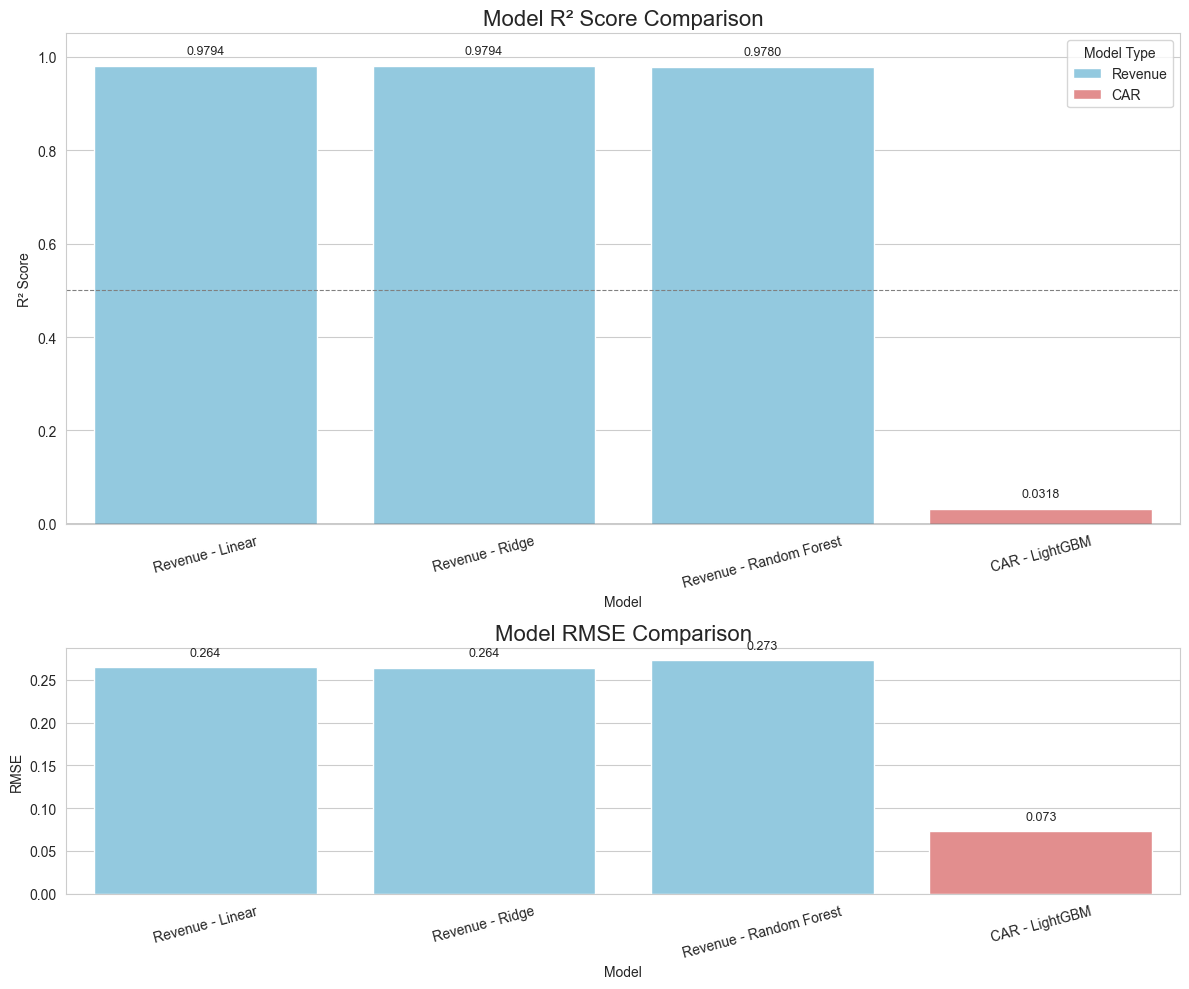

In [21]:
# ===========================
# 11. Graphs
# ===========================
# Model names and metrics
models = ['Revenue - Linear', 'Revenue - Ridge', 'Revenue - Random Forest', 'CAR - LightGBM']
r2_scores = [0.9794, 0.9794, 0.9780, 0.0318]
rmse_scores = [0.2644, 0.2643, 0.2729, 0.0732]

# Create dataframe
results_df = pd.DataFrame({
    'Model': models,
    'R2 Score': r2_scores,
    'RMSE': rmse_scores,
    'Type': ['Revenue', 'Revenue', 'Revenue', 'CAR']
})

# Set Seaborn style
sns.set_style("whitegrid")
palette = {'Revenue': 'skyblue', 'CAR': 'lightcoral'}

# Create two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot R²
sns.barplot(
    x='Model', 
    y='R2 Score', 
    hue='Type', 
    dodge=False,
    data=results_df,
    palette=palette,
    ax=axs[0]
)
axs[0].axhline(0, color='black', linewidth=1)
axs[0].axhline(0.5, color='gray', linestyle='--', linewidth=0.8)
axs[0].set_ylim(0, 1.05)
axs[0].set_ylabel('R² Score')
axs[0].set_title('Model R² Score Comparison', fontsize=16)
axs[0].legend(title='Model Type')
axs[0].set_xticklabels(models, rotation=15)

# Annotate R² values
for idx, row in results_df.iterrows():
    axs[0].text(
        idx, row['R2 Score'] + 0.02, 
        f"{row['R2 Score']:.4f}", 
        ha='center', va='bottom', fontsize=9
    )

# Plot RMSE
sns.barplot(
    x='Model',
    y='RMSE',
    hue='Type',
    dodge=False,
    data=results_df,
    palette=palette,
    ax=axs[1]
)
axs[1].set_ylabel('RMSE')
axs[1].set_title('Model RMSE Comparison', fontsize=16)
axs[1].legend_.remove()
axs[1].set_xticklabels(models, rotation=15)

# Annotate RMSE values
for idx, row in results_df.iterrows():
    axs[1].text(
        idx, row['RMSE'] + 0.01, 
        f"{row['RMSE']:.3f}", 
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()